In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [2]:
#Read the decidua anndata:
#Current file path (Eils-HPC): "/dh-projects/preeclampsia_2022/analysis/placenta_atlas_2022/decidua_anndata/SP014_SP136_decidua_analysis_010322.h5ad"
dec_results= "/data/analysis/preeclampsia_2019/placenta_atlas_2022/decidua_anndata/SP014_SP136_decidua_analysis_010322.h5ad"

ldata_dec01= sc.read_h5ad(dec_results)
ldata_dec01 #Before filtering the cell types such as DSC3. 

AnnData object with n_obs × n_vars = 69311 × 6000
    obs: 'donor_id', 'time', 'disease', 'tissue', 'smoking', 'cohort', 'library', 'procurement', 'placental_volume', 'gestational_weeks', 'gestational_days', 'maternal_BMI', 'maternal_age', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MT_genes', 'log1p_total_counts_MT_genes', 'pct_counts_MT_genes', 'total_counts_Ribo_genes', 'log1p_total_counts_Ribo_genes', 'pct_counts_Ribo_genes', 'total_counts_HB_genes', 'log1p_total_counts_HB_genes', 'pct_counts_HB_genes', 'percent_mt2', 'n_counts', 'percent_Ribo2', 'percent_HB2', 'n_genes', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'celltypist_majority_voting', 'celltypist_predicted_labels', 'donor_id_reordered', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'majority_voting', 'predicted_labels', 'conf_score', 'over_clustering', 'leiden', '_scvi_raw_norm_scaling', 'leiden_res1.5', 'leiden_res2', 'dMSC_leiden', 'celltyp

In [3]:
#Convert to raw matrix: 
ldata_dec= ldata_dec01.raw.to_adata()

ldata_dec

AnnData object with n_obs × n_vars = 69311 × 24859
    obs: 'donor_id', 'time', 'disease', 'tissue', 'smoking', 'cohort', 'library', 'procurement', 'placental_volume', 'gestational_weeks', 'gestational_days', 'maternal_BMI', 'maternal_age', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MT_genes', 'log1p_total_counts_MT_genes', 'pct_counts_MT_genes', 'total_counts_Ribo_genes', 'log1p_total_counts_Ribo_genes', 'pct_counts_Ribo_genes', 'total_counts_HB_genes', 'log1p_total_counts_HB_genes', 'pct_counts_HB_genes', 'percent_mt2', 'n_counts', 'percent_Ribo2', 'percent_HB2', 'n_genes', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'celltypist_majority_voting', 'celltypist_predicted_labels', 'donor_id_reordered', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'majority_voting', 'predicted_labels', 'conf_score', 'over_clustering', 'leiden', '_scvi_raw_norm_scaling', 'leiden_res1.5', 'leiden_res2', 'dMSC_leiden', 'cellty

In [4]:
#Map the donor_ID a/c to Graz clinical donor records. 
ldata_dec.obs['donor_id_renamed'] = (ldata_dec.obs["donor_id"].map(lambda x: {"Donor-17025-decidua": "17-025-d", "Donor-SEKR2-decidua": "17-022-d",
"Donor-SOZE1-decidua": "17-021-d", "Donor-327-decidua": "327-d", "Donor-328-decidua": "328-d", 
"Donor-372-decidua": "372-d", "Donor13_SP136": "073-d", "Donor14_SP136": "100-d", 
"Donor15_SP136": "102-d", "Donor-274-decidua": "274-d", "Donor-389-decidua": "389-d", 
"Donor-419-decidua": "419-d"}.get(x, x)).astype("category"))


ldata_dec.obs['donor_id_reordered']= ldata_dec.obs['donor_id_renamed'].cat.reorder_categories(["17-025-d", "17-022-d", 
"17-021-d", "327-d", "328-d", "372-d", "073-d", "100-d", "102-d", "274-d", "389-d", "419-d"])

ldata_dec.obs['donor_id_reordered'].cat.categories

Index(['17-025-d', '17-022-d', '17-021-d', '327-d', '328-d', '372-d', '073-d',
       '100-d', '102-d', '274-d', '389-d', '419-d'],
      dtype='object')

In [7]:
#The number of genes with at least one positive count in a cell. 
ldata_dec.obs['n_genes_by_counts'] 

ACGTCAACAAGGACAC-1-0-0    7080
TTAGGACCACACAGAG-1-0-0    5234
ATCATCTTCCTTTCGG-1-0-0    5509
ATCTACTGTTCCTCCA-1-0-0    5362
TTATGCTTCATTGCCC-1-0-0    3405
                          ... 
GTTCTATGTCCTATAG-1-2-1     208
GTCATGAAGAGATTCA-1-2-1     204
TCCTTTCAGATAGGGA-1-2-1     212
TCATGTTCATTGCTGA-1-2-1     210
GCCTGTTGTGAGGAAA-1-2-1     222
Name: n_genes_by_counts, Length: 69311, dtype: category
Categories (4879, object): ['200', '201', '202', '203', ..., '8787', '8840', '8919', '9251']

In [9]:
ldata_dec.obs= ldata_dec.obs.astype('category')

In [13]:
#mitochondrial genes
ldata_dec.var['MT_genes'] = ldata_dec.var_names.str.startswith('MT-') 
#ribosomal genes
ldata_dec.var['Ribo_genes'] = ldata_dec.var_names.str.startswith(("RPS","RPL"))
#hemoglobin genes.
ldata_dec.var['HB_genes'] = ldata_dec.var_names.str.contains(("^HB[^(P)]"))

#Calculate the QC using scanpy's in built function: 
sc.pp.calculate_qc_metrics(ldata_dec, qc_vars=['MT_genes','Ribo_genes','HB_genes'], percent_top=None, inplace=True)

#Percentage of MT transcripts:
mito_genes = ldata_dec.var_names.str.startswith('MT-')

#For each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
ldata_dec.obs['percent_mt2'] = np.sum(ldata_dec[:, mito_genes].X, axis=1).A1 / np.sum(ldata_dec.X, axis=1).A1

#Add the total counts per cell as observations-annotation to adata:
ldata_dec.obs['n_counts'] = ldata_dec.X.sum(axis=1).A1

In [25]:
sc.settings.set_figure_params(dpi=100)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,3)
plt.rcParams["axes.grid"] = False

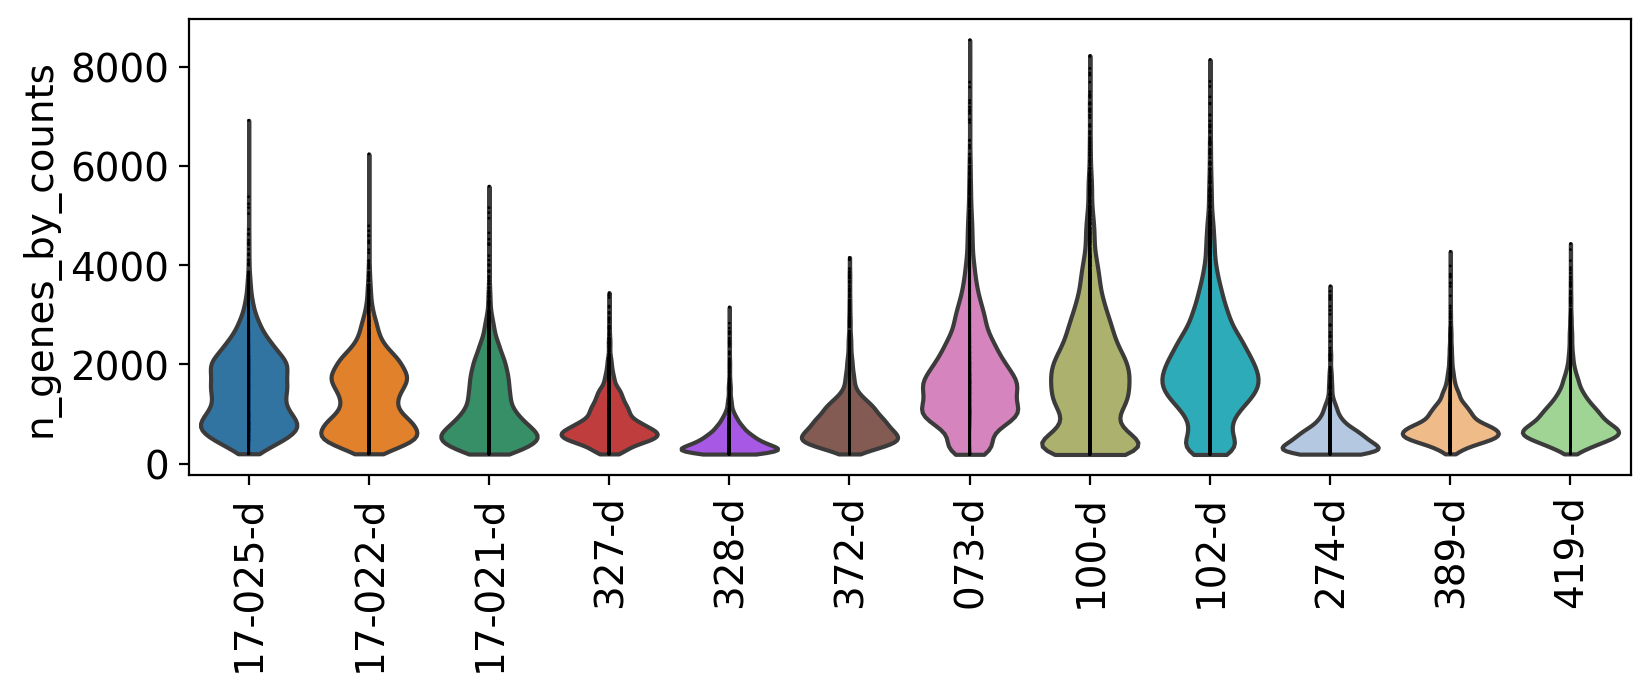

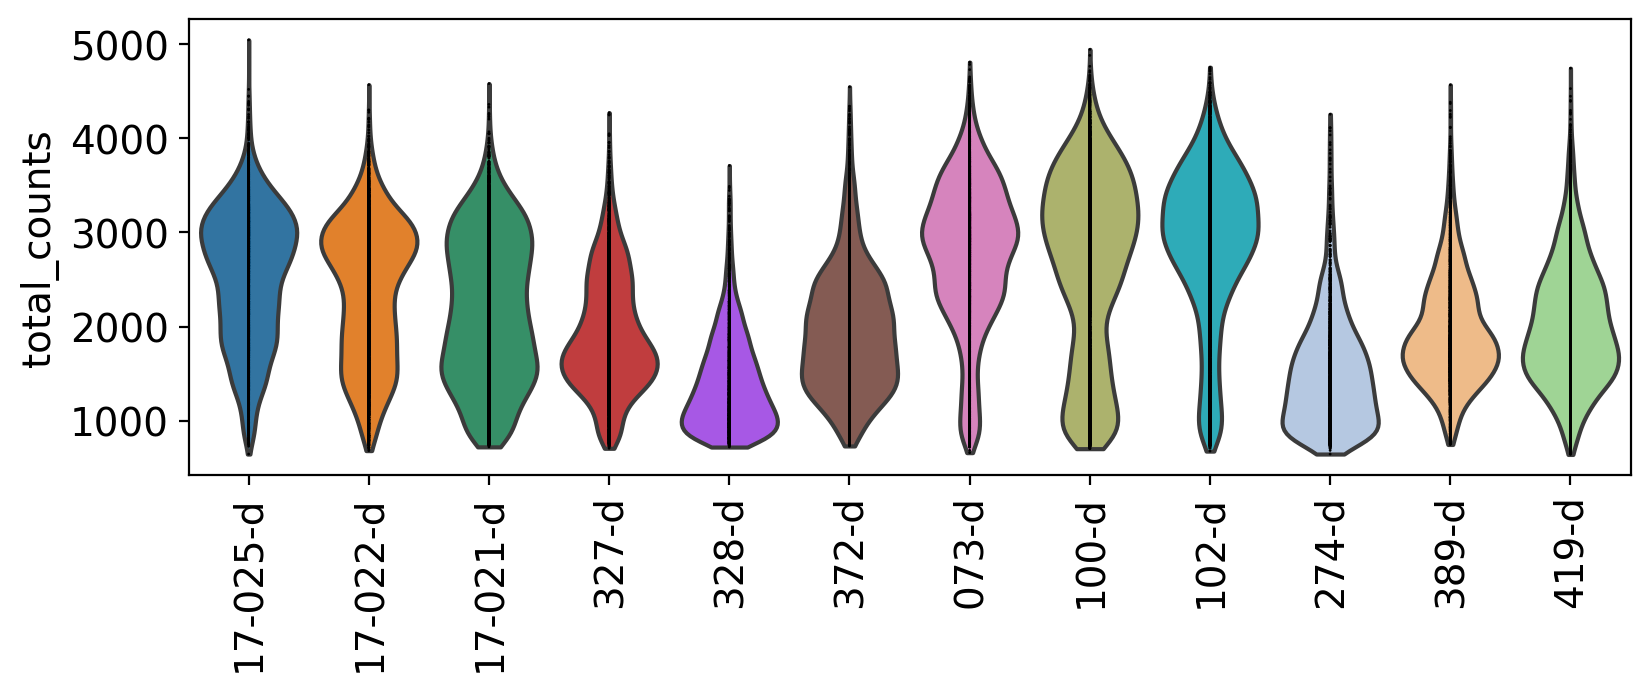

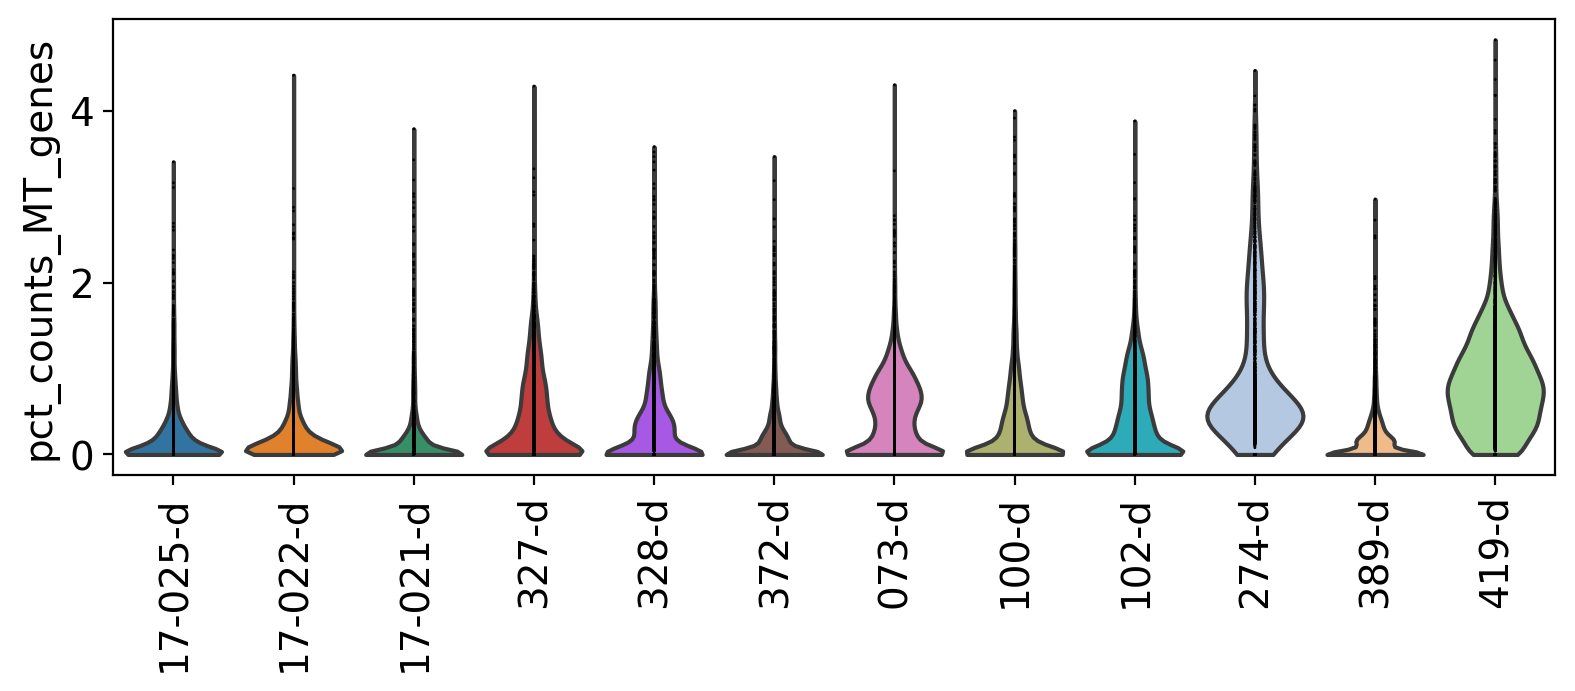

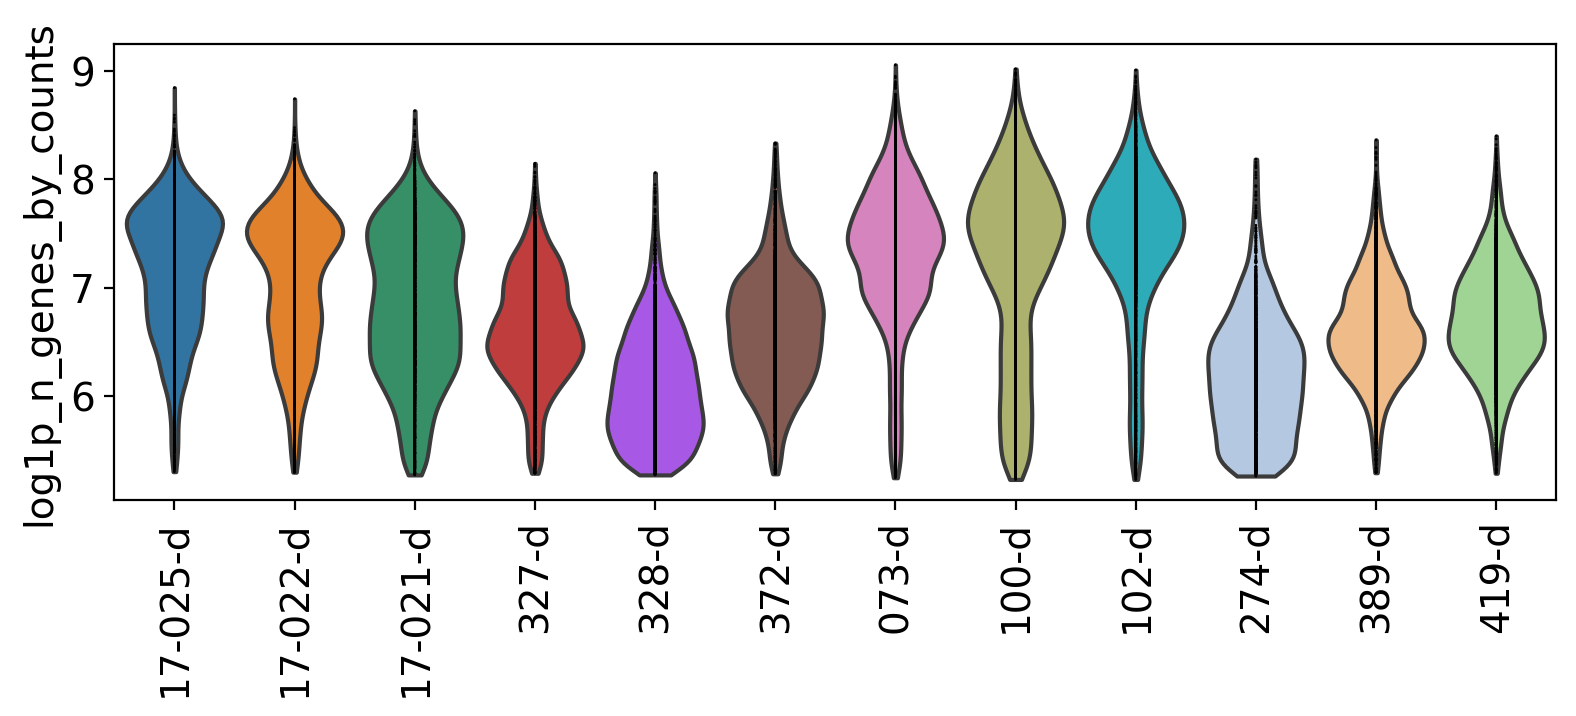

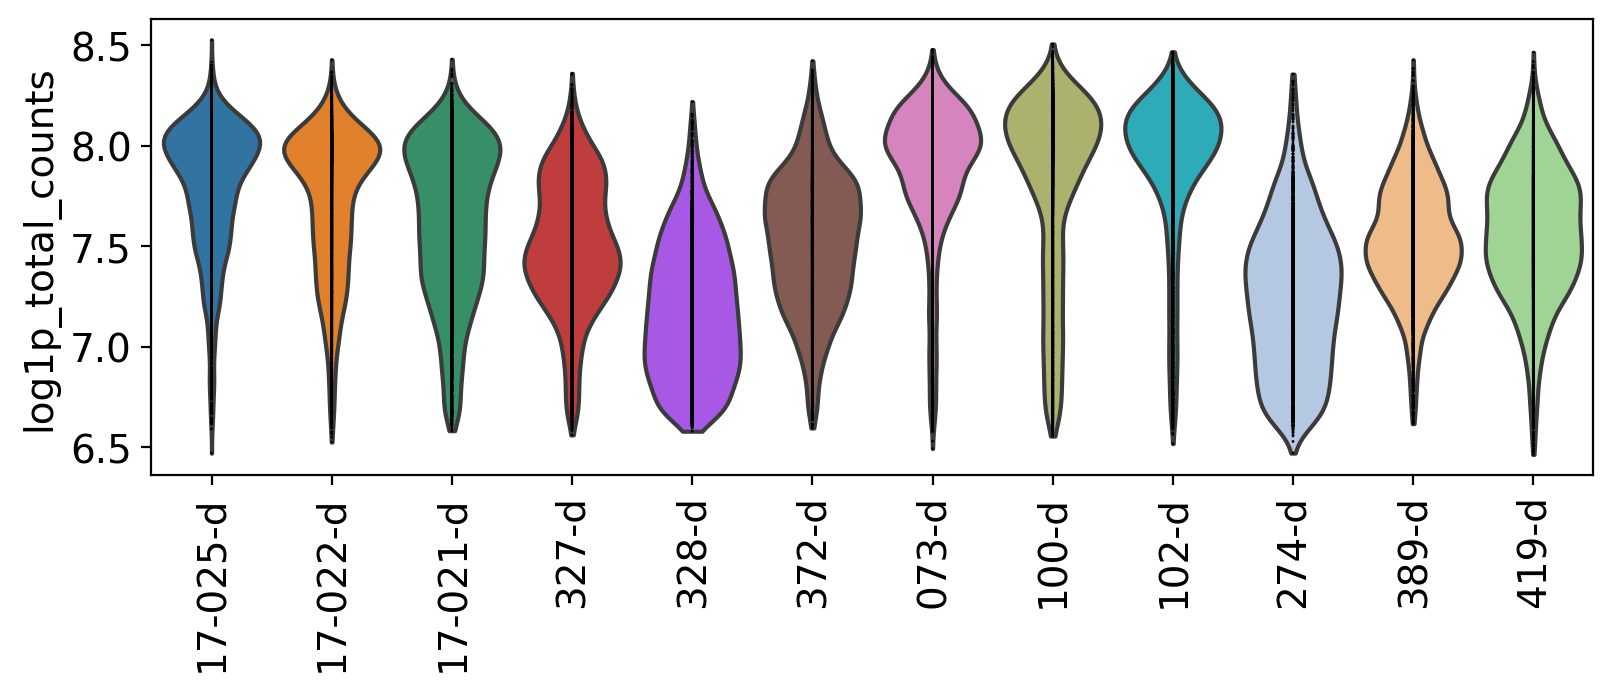

In [26]:
sc.pl.violin(ldata_dec, ['n_genes_by_counts'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_Decidua_nGenes_VP.pdf')
sc.pl.violin(ldata_dec, ['total_counts'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_Decidua_UMI_VP.pdf')
sc.pl.violin(ldata_dec, ['pct_counts_MT_genes'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_Decidua_pctMT_VP.pdf')

sc.pl.violin(ldata_dec, ['log1p_n_genes_by_counts'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_Decidua_log1p_nGenes.pdf')
sc.pl.violin(ldata_dec, ['log1p_total_counts'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_Decidua_log1p_totalcounts.pdf')

In [15]:
ldata_dec.raw 

In [27]:
#Read placenta dataset: 
##Before filtering the cell types.

#Current file path (Eils-HPC): "/dh-projects/preeclampsia_2022/analysis/placenta_atlas_2022/villi_anndata/SP014_SP082_SP136_placenta.h5ad"
results_villi= "/data/analysis/preeclampsia_2019/placenta_atlas_2022/villi_anndata/SP014_SP082_SP136_placenta.h5ad"

adata_hvg= sc.read_h5ad(results_villi)
adata_hvg

AnnData object with n_obs × n_vars = 147945 × 26202
    obs: 'batch', 'cohort', 'disease', 'donor_id', 'gestational_days', 'gestational_weeks', 'library', 'maternal_BMI', 'maternal_age', 'placental_volume', 'procurement', 'smoking', 'time', 'tissue', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MT_genes', 'log1p_total_counts_MT_genes', 'pct_counts_MT_genes', 'total_counts_Ribo_genes', 'log1p_total_counts_Ribo_genes', 'pct_counts_Ribo_genes', 'total_counts_HB_genes', 'log1p_total_counts_HB_genes', 'pct_counts_HB_genes', 'percent_mt2', 'n_counts', 'percent_Ribo2', 'percent_HB2', 'n_genes', 'XIST-counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', '_scvi_local_l_mean', '_scvi_local_l_var', 'leiden', 'celltypist_majority_voting', 'celltypist_predicted_labels', 'LDA_topic_0', 'LDA_topic_1', 'LDA_topic_2', 'LDA_topic_3', 'LDA_topic_4', 'LDA_topic_5', 'LDA_topic_6', 'LDA_topic_7', 'LDA_topic_8', 'LDA_topic_9', 'LDA_to

In [28]:
adata_hvg.raw

In [29]:
adata_hvg.layers['counts']= adata_hvg.X

adata_hvg.raw= adata_hvg #keep raw slot safe

In [30]:
adata_hvg.raw

In [31]:
#Merge the decidua data with that of villi:
adata_all= ldata_dec.concatenate(adata_hvg)

adata_all

/home/debnatho/anaconda3/envs/scvi_analysis/lib/python3.7/site-packages/anndata/_core/merge.py:918: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.
  UserWarning,


AnnData object with n_obs × n_vars = 217256 × 23891
    obs: 'donor_id', 'time', 'disease', 'tissue', 'smoking', 'cohort', 'library', 'procurement', 'placental_volume', 'gestational_weeks', 'gestational_days', 'maternal_BMI', 'maternal_age', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_MT_genes', 'log1p_total_counts_MT_genes', 'pct_counts_MT_genes', 'total_counts_Ribo_genes', 'log1p_total_counts_Ribo_genes', 'pct_counts_Ribo_genes', 'total_counts_HB_genes', 'log1p_total_counts_HB_genes', 'pct_counts_HB_genes', 'percent_mt2', 'n_counts', 'percent_Ribo2', 'percent_HB2', 'n_genes', 'XIST-counts', 'S_score', 'G2M_score', 'phase', 'celltypist_majority_voting', 'celltypist_predicted_labels', 'donor_id_reordered', 'seed_labels', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'majority_voting', 'predicted_labels', 'conf_score', 'over_clustering', 'leiden', '_scvi_raw_norm_scaling', 'leiden_res1.5', 'leiden_res2', 'dMSC_leiden', 'cellt

In [32]:
#adata_all= adata_all.raw.to_adata()

#adata_all

In [33]:
#mitochondrial genes
adata_all.var['MT_genes'] = adata_all.var_names.str.startswith('MT-') 
#ribosomal genes
adata_all.var['Ribo_genes'] = adata_all.var_names.str.startswith(("RPS","RPL"))
#hemoglobin genes.
adata_all.var['HB_genes'] = adata_all.var_names.str.contains(("^HB[^(P)]"))

#Calculate the QC using scanpy's in built function: 
sc.pp.calculate_qc_metrics(adata_all, qc_vars=['MT_genes','Ribo_genes','HB_genes'], percent_top=None, inplace=True)

In [34]:
adata_all.obs['donor_id']= adata_all.obs['donor_id'].astype('category')

In [35]:
adata_all.obs['donor_id'].cat.categories

Index(['Donor-17025-decidua', 'Donor-17025-villi', 'Donor-274-decidua',
       'Donor-327-decidua', 'Donor-327-villi', 'Donor-328-decidua',
       'Donor-328-villi', 'Donor-372-decidua', 'Donor-372-villi',
       'Donor-389-decidua', 'Donor-389-villi', 'Donor-419-decidua',
       'Donor-419-villi', 'Donor-557_1-villi', 'Donor-557_2-villi',
       'Donor-SEKR2-decidua', 'Donor-SEKR2-villi', 'Donor-SOZE1-decidua',
       'Donor-SOZE1-villi', 'Donor-Term01', 'Donor-Term02', 'Donor-Term03',
       'Donor11', 'Donor12', 'Donor13_SP136', 'Donor14_SP136', 'Donor15_SP136',
       'Donor34', 'Donor37', 'Donor38', 'Donor39', 'Donor41', 'SP136_022v',
       'SP136_023v'],
      dtype='object')

In [36]:
#Map the donor_ID(s) a/c to Graz clinical data. 
adata_all.obs['donor_id_renamed'] = (adata_all.obs["donor_id"].map(lambda x: {"Donor-17025-villi": "17-025-v",
"Donor-SEKR2-villi": "17-022-v", "Donor-SOZE1-villi": "17-021-v", "Donor11": "18-082-01-v", "Donor12": "18-108-02-v", 
"Donor34": "18-032-v", "Donor37": "18-017-v", "Donor38": "18-033-v", "Donor39": "18-098-v", "Donor41": "20-027-v", 
"Donor-327-villi": "327-v", "Donor-328-villi": "328-v", "Donor-372-villi": "372-v", "Donor-Term01": "TRM1-v", 
"Donor-Term02": "TRM2-v", "Donor-Term03": "TRM3-v", "Donor-389-villi": "389-v", "Donor-419-villi": "419-v", 
"Donor-557_1-villi": "577-1-v", "Donor-557_2-villi": "577-2-v", "SP136_022v": "M181-v", "SP136_023v": "PLA120-v",
"Donor-17025-decidua": "17-025-d", "Donor-SEKR2-decidua": "17-022-d",
"Donor-SOZE1-decidua": "17-021-d", "Donor-327-decidua": "327-d", "Donor-328-decidua": "328-d", 
"Donor-372-decidua": "372-d", "Donor13_SP136": "073-d", "Donor14_SP136": "100-d", 
"Donor15_SP136": "102-d", "Donor-274-decidua": "274-d", "Donor-389-decidua": "389-d", 
"Donor-419-decidua": "419-d"}.get(x, x)).astype("category"))

In [37]:
adata_all.obs['donor_id_renamed'].cat.categories #renamed a/c to manuscript. 

Index(['17-025-d', '17-025-v', '274-d', '327-d', '327-v', '328-d', '328-v',
       '372-d', '372-v', '389-d', '389-v', '419-d', '419-v', '577-1-v',
       '577-2-v', '17-022-d', '17-022-v', '17-021-d', '17-021-v', 'TRM1-v',
       'TRM2-v', 'TRM3-v', '18-082-01-v', '18-108-02-v', '073-d', '100-d',
       '102-d', '18-032-v', '18-017-v', '18-033-v', '18-098-v', '20-027-v',
       'M181-v', 'PLA120-v'],
      dtype='object')

In [38]:
#Reorder the categories (first villi & then, decidua): 
#Early, term controls & PE (order inside a tissue): 
adata_all.obs['donor_id_reordered']= adata_all.obs['donor_id_renamed'].cat.reorder_categories(["17-025-v",
"17-022-v", "17-021-v", "18-082-01-v", "18-108-02-v", "18-032-v", "18-017-v", "18-033-v", "18-098-v", 
"20-027-v", "327-v",  "328-v", "372-v", "TRM1-v", "TRM2-v", "TRM3-v", "389-v", "419-v", 
"577-1-v", "577-2-v", "M181-v", "PLA120-v", "17-025-d", "17-022-d", "17-021-d", "327-d", "328-d", 
"372-d", "073-d", "100-d", "102-d", "274-d", "389-d", "419-d"])

adata_all.obs['donor_id_reordered'].cat.categories

Index(['17-025-v', '17-022-v', '17-021-v', '18-082-01-v', '18-108-02-v',
       '18-032-v', '18-017-v', '18-033-v', '18-098-v', '20-027-v', '327-v',
       '328-v', '372-v', 'TRM1-v', 'TRM2-v', 'TRM3-v', '389-v', '419-v',
       '577-1-v', '577-2-v', 'M181-v', 'PLA120-v', '17-025-d', '17-022-d',
       '17-021-d', '327-d', '328-d', '372-d', '073-d', '100-d', '102-d',
       '274-d', '389-d', '419-d'],
      dtype='object')

In [39]:
sc.settings.set_figure_params(dpi=100)

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,6)
plt.rcParams["axes.grid"] = False

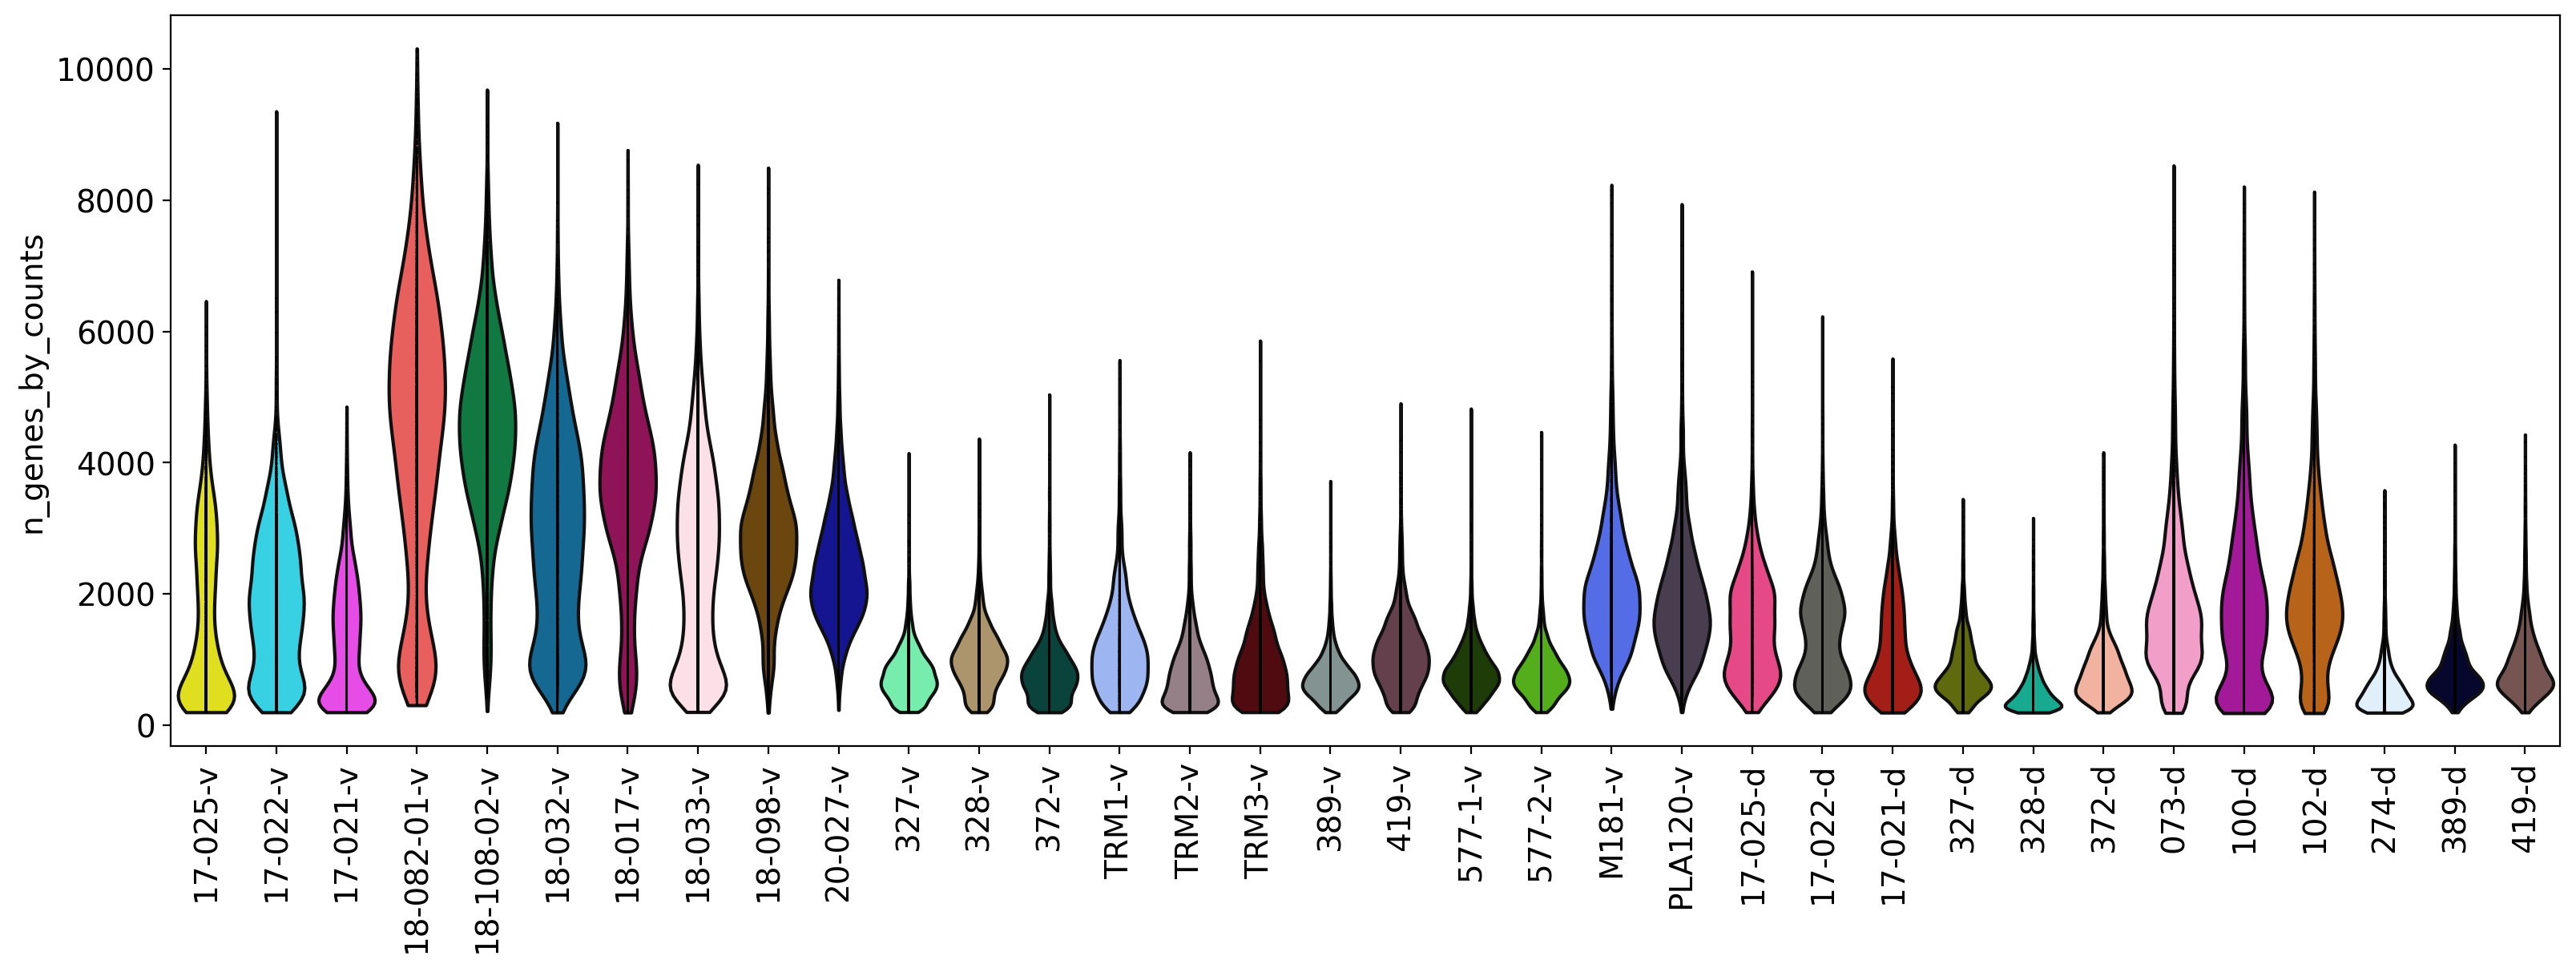

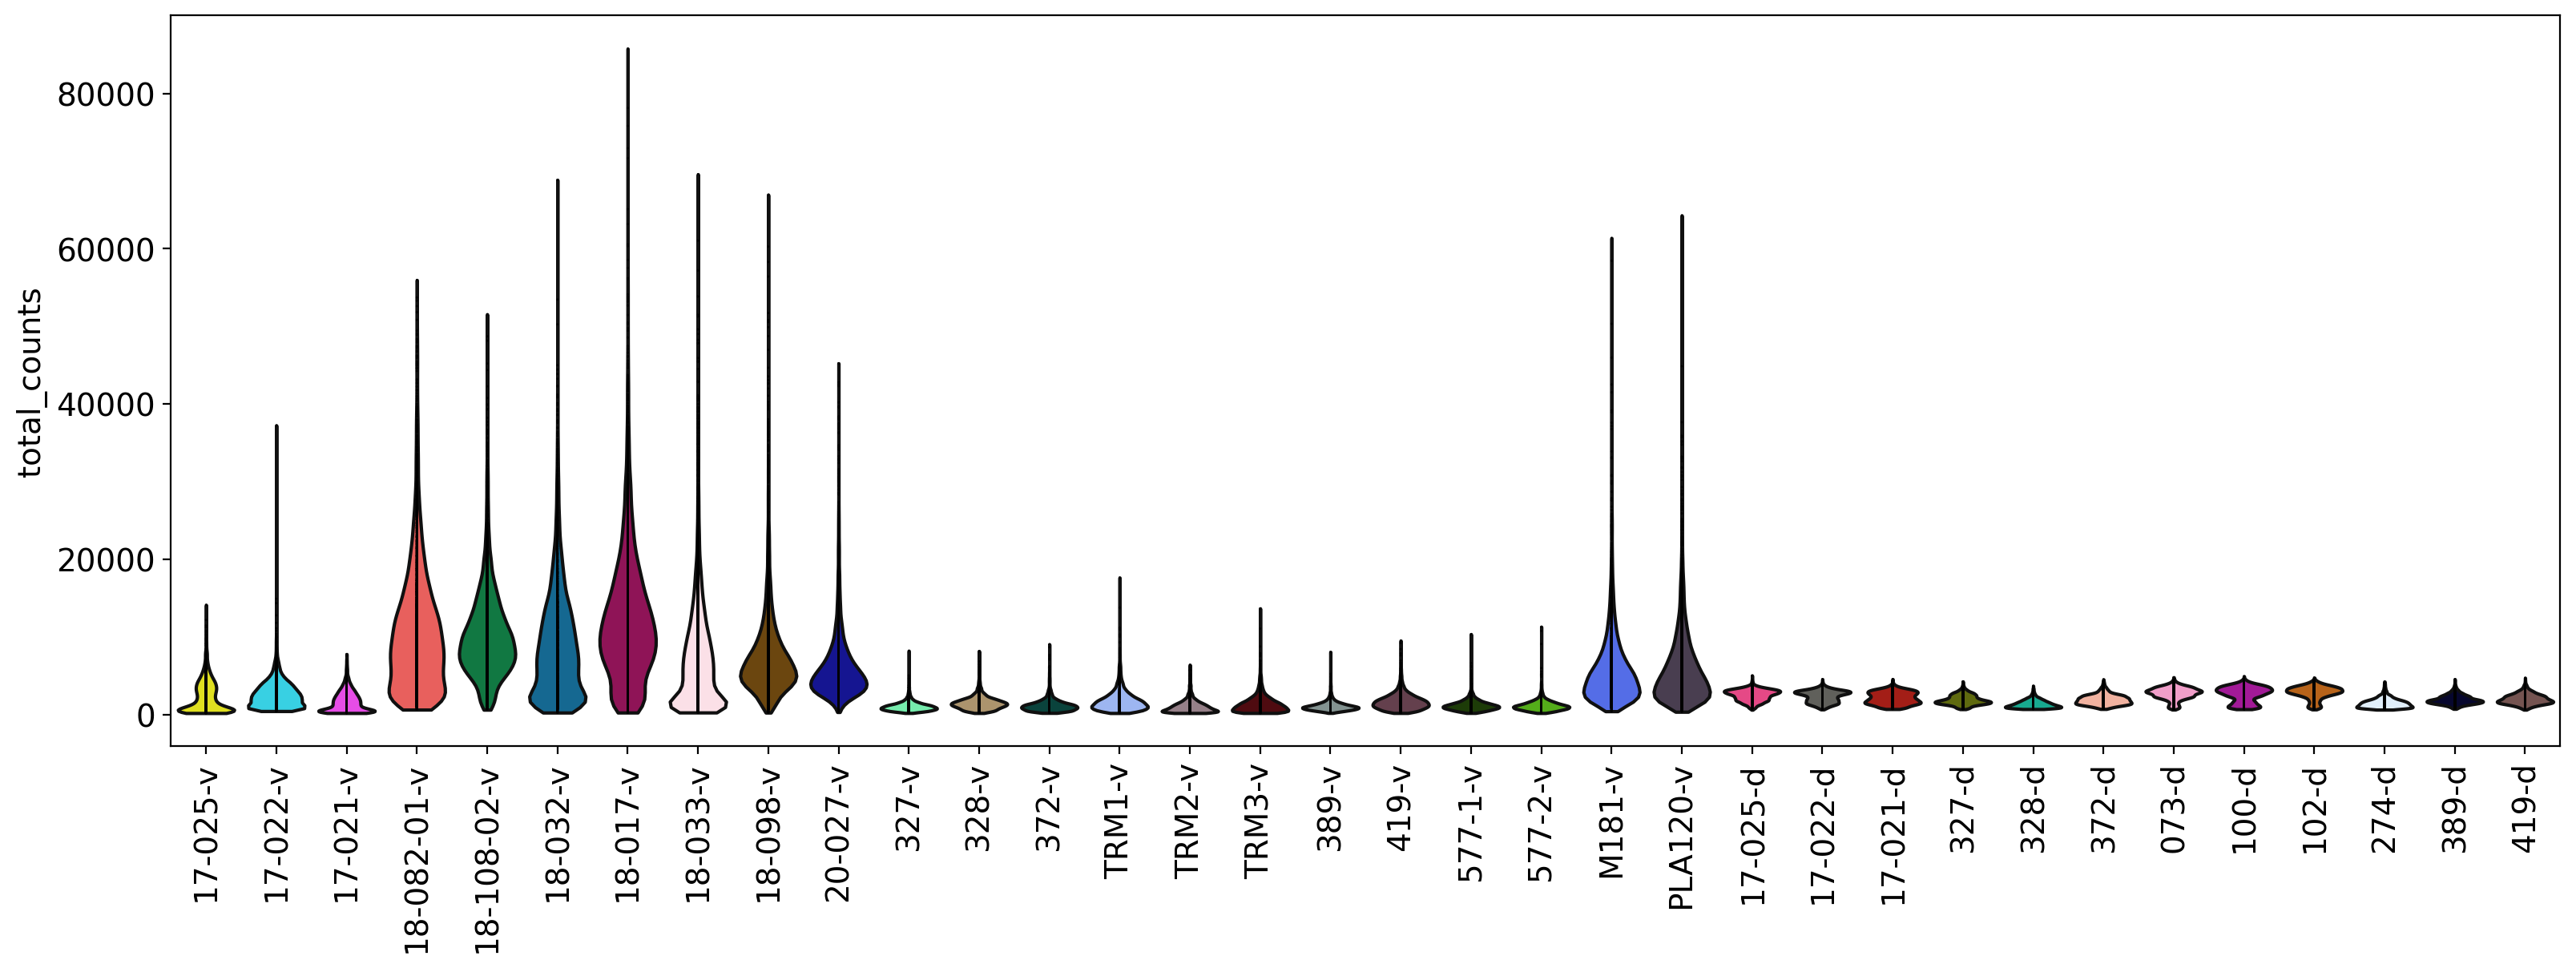

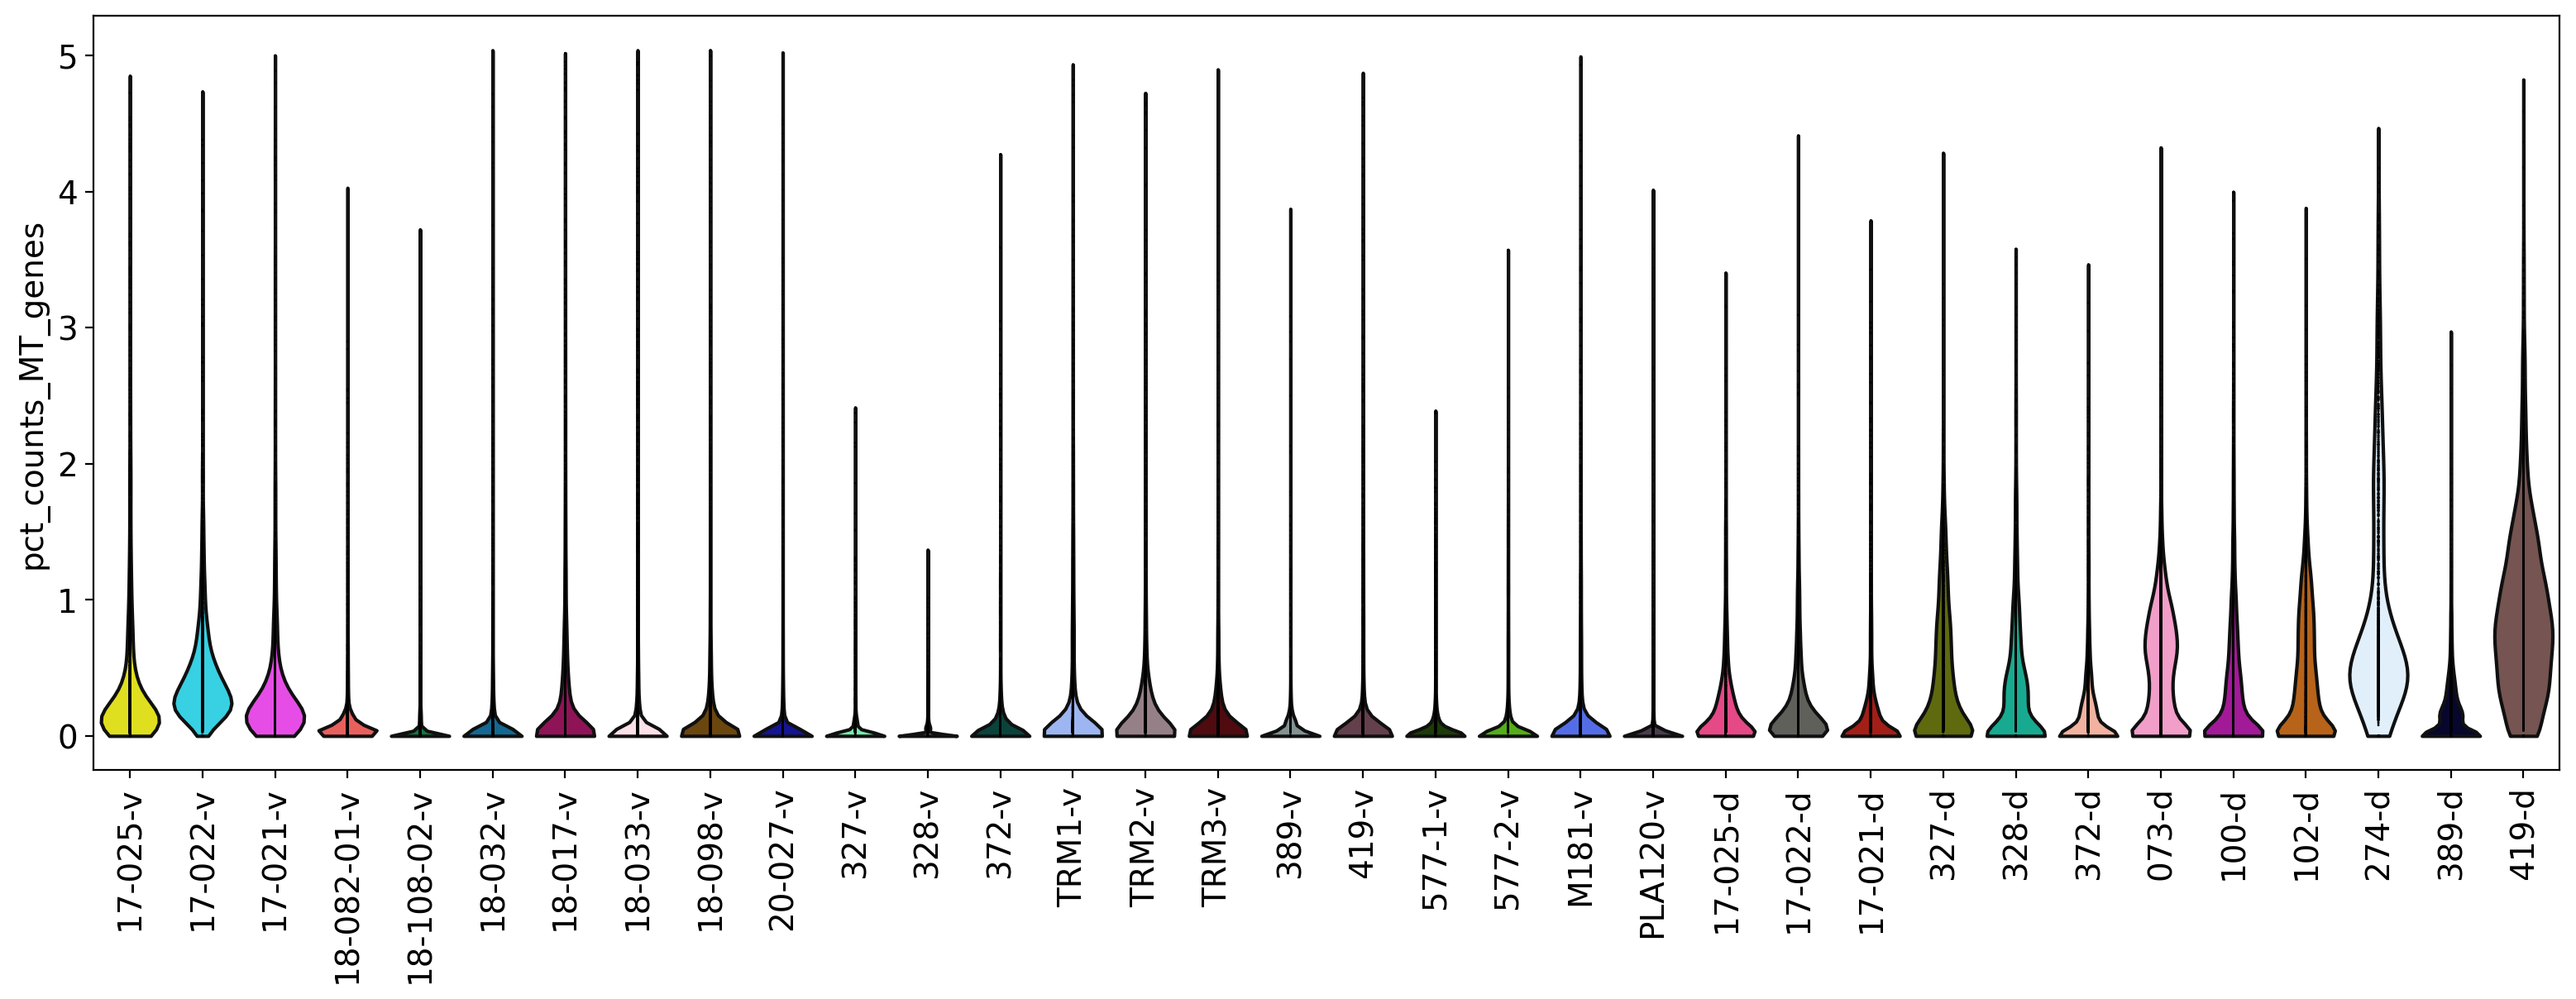

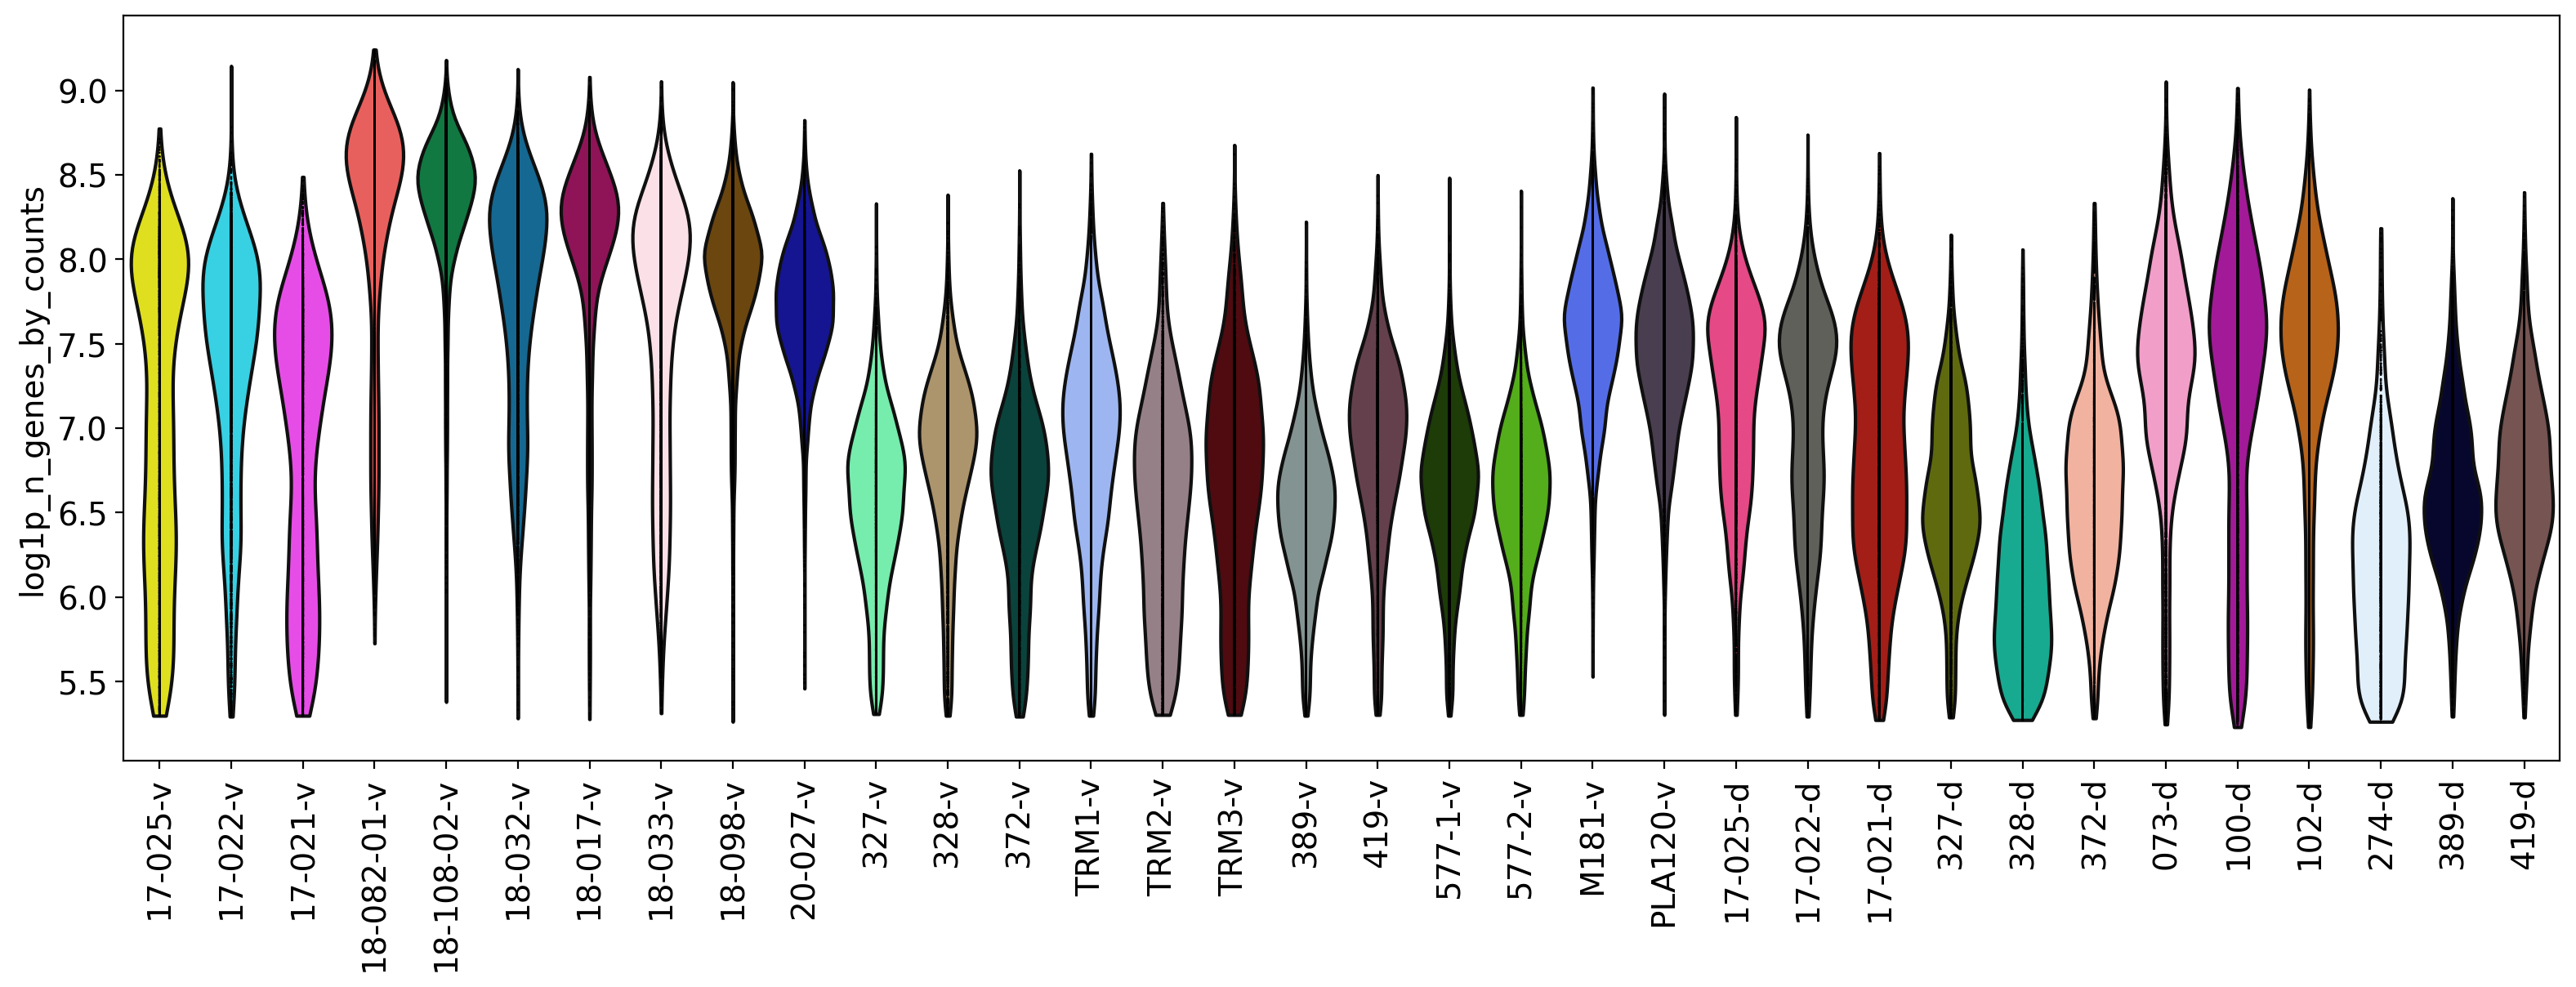

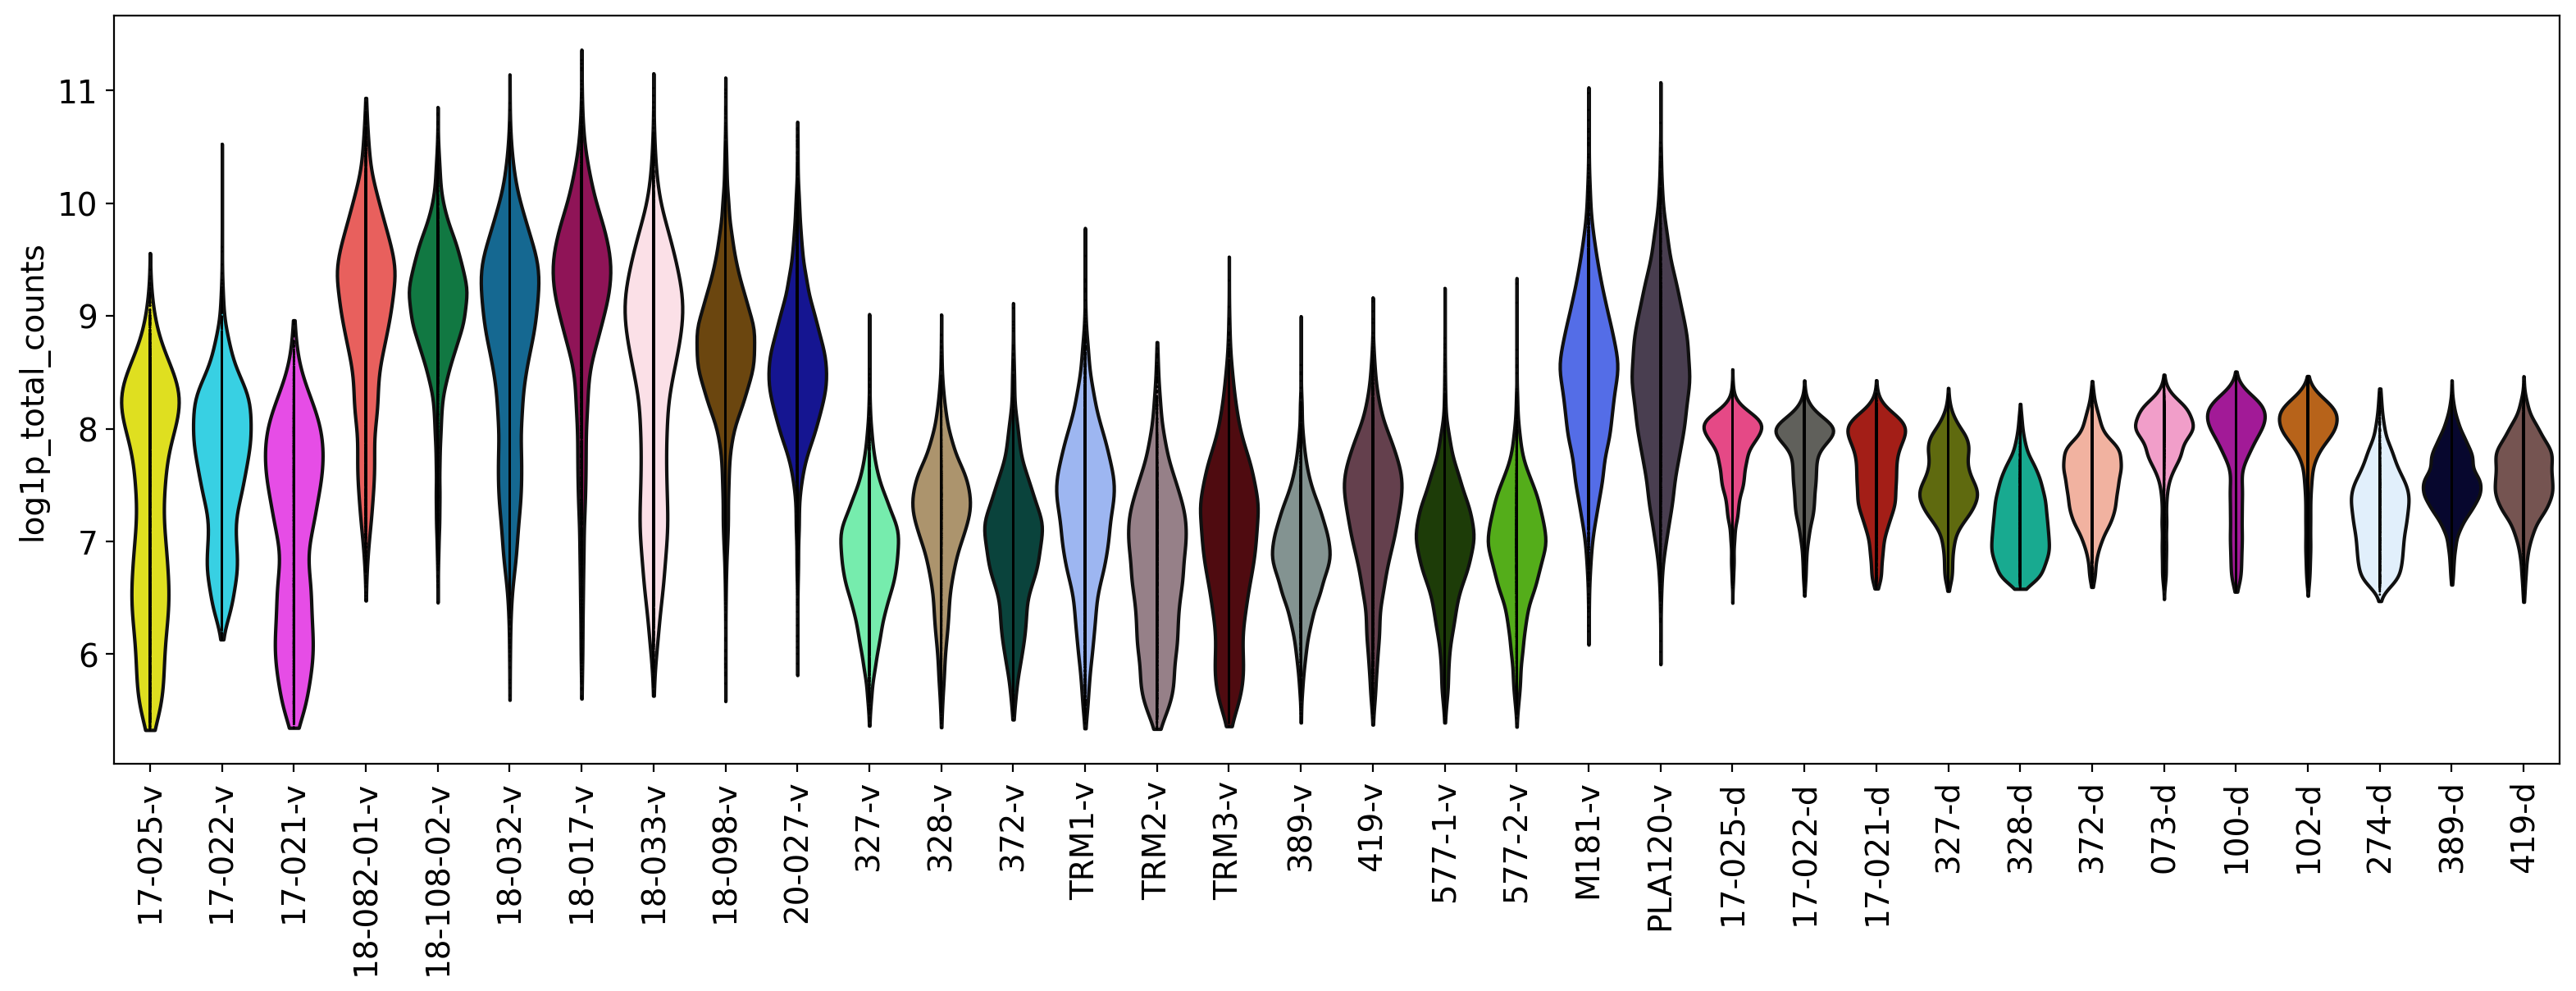

In [41]:
sc.pl.violin(adata_all, ['n_genes_by_counts'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_atlas_nGenes_VP.pdf')
sc.pl.violin(adata_all, ['total_counts'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_atlas_UMI_VP.pdf')
sc.pl.violin(adata_all, ['pct_counts_MT_genes'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_atlas_pctMT_VP.pdf')

sc.pl.violin(adata_all, ['log1p_n_genes_by_counts'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_atlas_log1p_nGenes.pdf')
sc.pl.violin(adata_all, ['log1p_total_counts'],jitter=0, groupby = 'donor_id_reordered', rotation= 90, save= '_atlas_log1p_totalcounts.pdf')

... storing 'tissue' as categorical
... storing 'cohort' as categorical
... storing 'placental_volume' as categorical
... storing 'gestational_weeks' as categorical
... storing 'gestational_days' as categorical
... storing 'maternal_BMI' as categorical
... storing 'maternal_age' as categorical
... storing 'percent_Ribo2' as categorical
... storing 'percent_HB2' as categorical
... storing 'n_genes' as categorical
... storing 'XIST-counts' as categorical
... storing 'S_score' as categorical
... storing 'G2M_score' as categorical
... storing 'celltypist_majority_voting' as categorical
... storing 'celltypist_predicted_labels' as categorical
... storing 'seed_labels' as categorical
... storing 'C_scANVI' as categorical
... storing 'majority_voting' as categorical
... storing 'predicted_labels' as categorical
... storing 'conf_score' as categorical
... storing 'over_clustering' as categorical
... storing 'leiden' as categorical
... storing '_scvi_raw_norm_scaling' as categorical
... storing

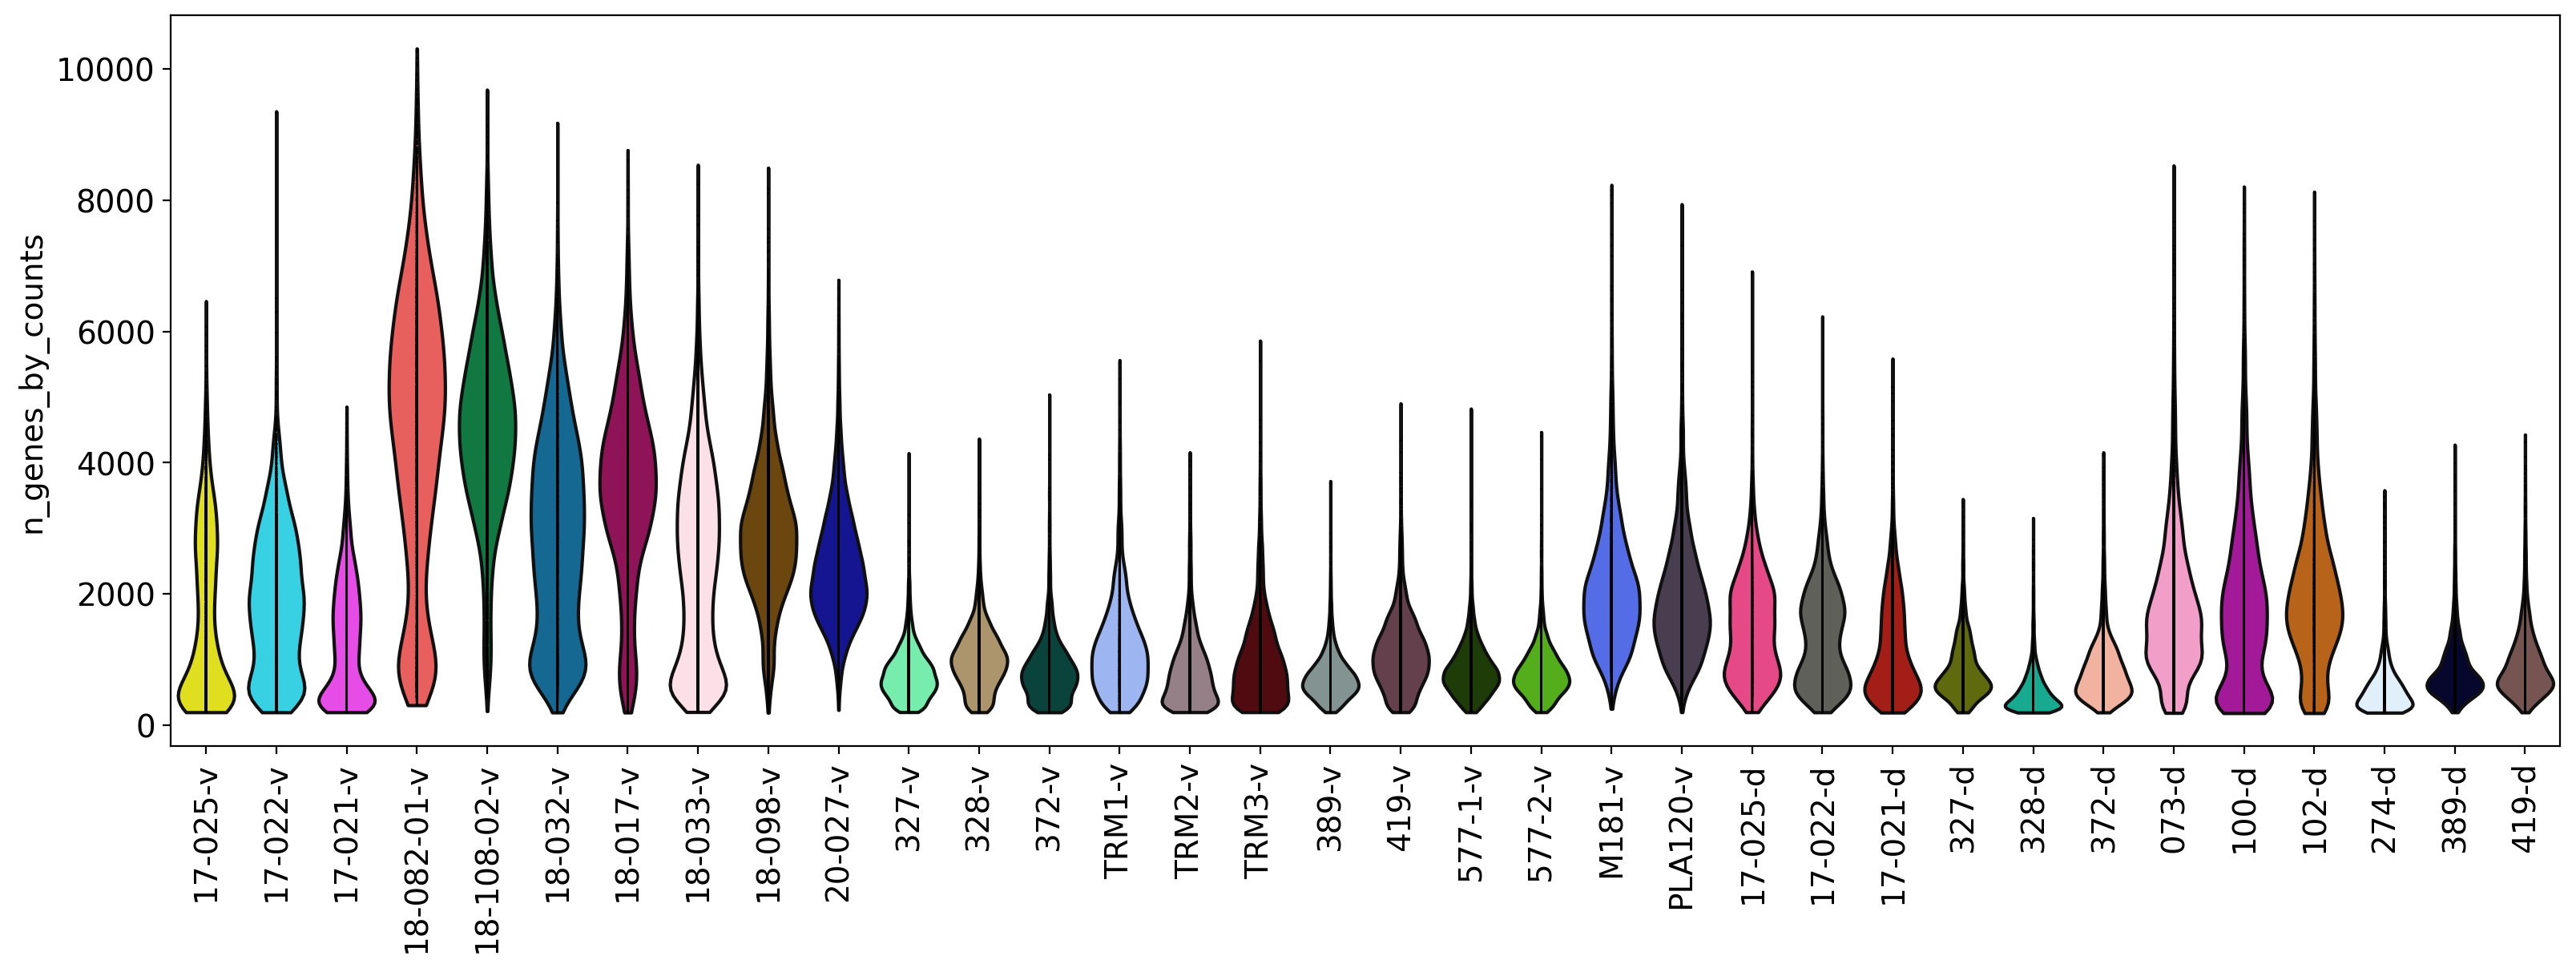

In [40]:
#test:
sc.pl.violin(adata_all, ['n_genes_by_counts'],jitter=0, groupby = 'donor_id_reordered', rotation= 90)

In [42]:
adata_all.obs['donor_id_reordered']

ACGTCAACAAGGACAC-1-0-0-0    17-025-d
TTAGGACCACACAGAG-1-0-0-0    17-025-d
ATCATCTTCCTTTCGG-1-0-0-0    17-025-d
ATCTACTGTTCCTCCA-1-0-0-0    17-025-d
TTATGCTTCATTGCCC-1-0-0-0    17-025-d
                              ...   
CTGATAGCAGTTCATG-1-5-1-1     577-2-v
CAAGATCCACCTCGGA-1-5-1-1     577-2-v
ACGCCGAGTGCCTTGG-1-5-1-1     577-2-v
TTTCCTCCAGCGAACA-1-5-1-1     577-2-v
CGGAGCTGTCATACTG-1-5-1-1     577-2-v
Name: donor_id_reordered, Length: 217256, dtype: category
Categories (34, object): ['17-025-v', '17-022-v', '17-021-v', '18-082-01-v', ..., '102-d', '274-d', '389-d', '419-d']